In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

In [5]:
df = pd.read_csv("titanic.csv")

df = df[["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]].copy()
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

df["Embarked"] = df["Embarked"].fillna("S")
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)

df["Age"] = df["Age"].fillna(df["Age"].median())

X = df.drop("Survived", axis=1)
y = df["Survived"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

modelo = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(300,),
        activation="relu",
        solver="adam",
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=50,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        random_state=42,
        verbose=False
    ))
])

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [7]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}\n")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy : 0.7933
Precision (macro): 0.8015
Recall    (macro): 0.7562
F1        (macro): 0.7671

              precision    recall  f1-score   support

           0       0.78      0.92      0.85       110
           1       0.82      0.59      0.69        69

    accuracy                           0.79       179
   macro avg       0.80      0.76      0.77       179
weighted avg       0.80      0.79      0.79       179



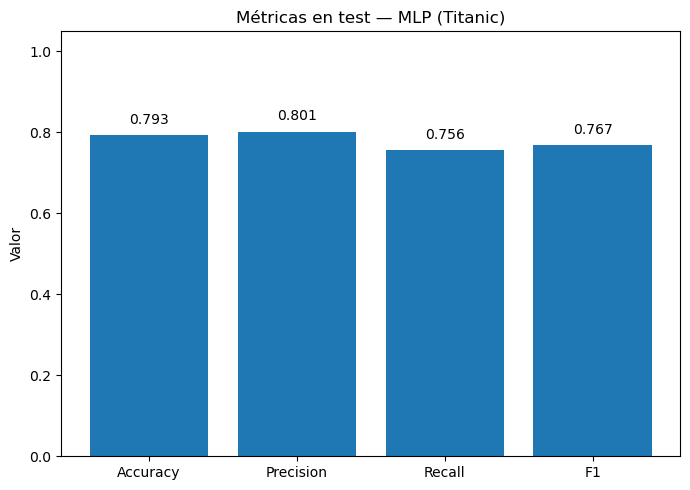

In [8]:
metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metric_vals  = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
bars = plt.bar(metric_names, metric_vals)
plt.ylim(0, 1.05)
plt.title("Métricas en test — MLP (Titanic)")
plt.ylabel("Valor")
for rect, val in zip(bars, metric_vals):
    h = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, h + 0.02, f"{val:.3f}",
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

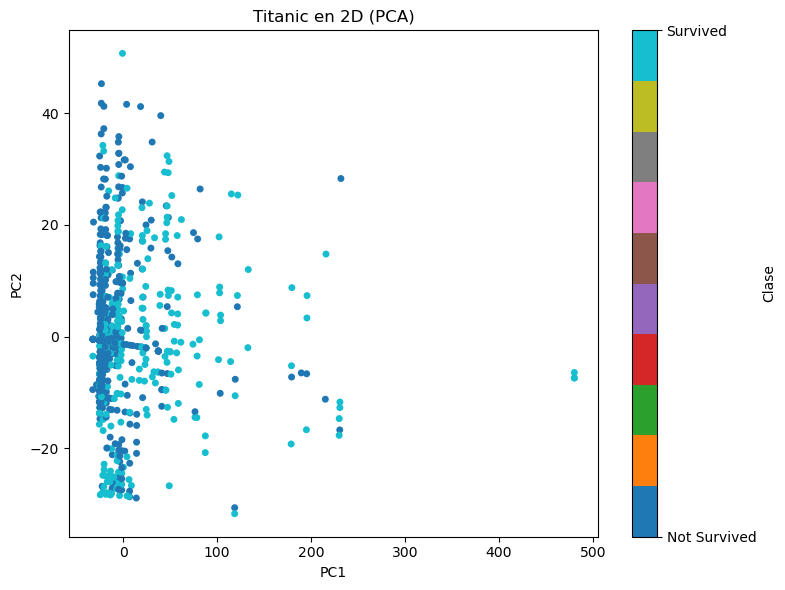

In [9]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab10", s=25, edgecolor="none")
plt.title("Titanic en 2D (PCA)")
plt.xlabel("PC1"); plt.ylabel("PC2")
cbar = plt.colorbar(scatter, ticks=[0,1])
cbar.set_label("Clase")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["Not Survived","Survived"])
plt.tight_layout()
plt.show()

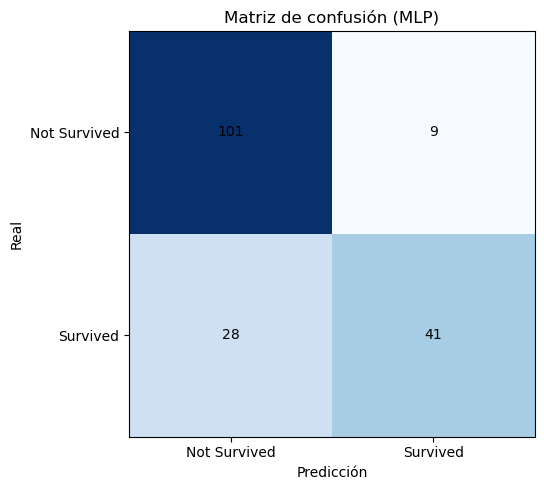

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Matriz de confusión (MLP)")
plt.xticks(ticks=[0,1], labels=["Not Survived","Survived"])
plt.yticks(ticks=[0,1], labels=["Not Survived","Survived"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

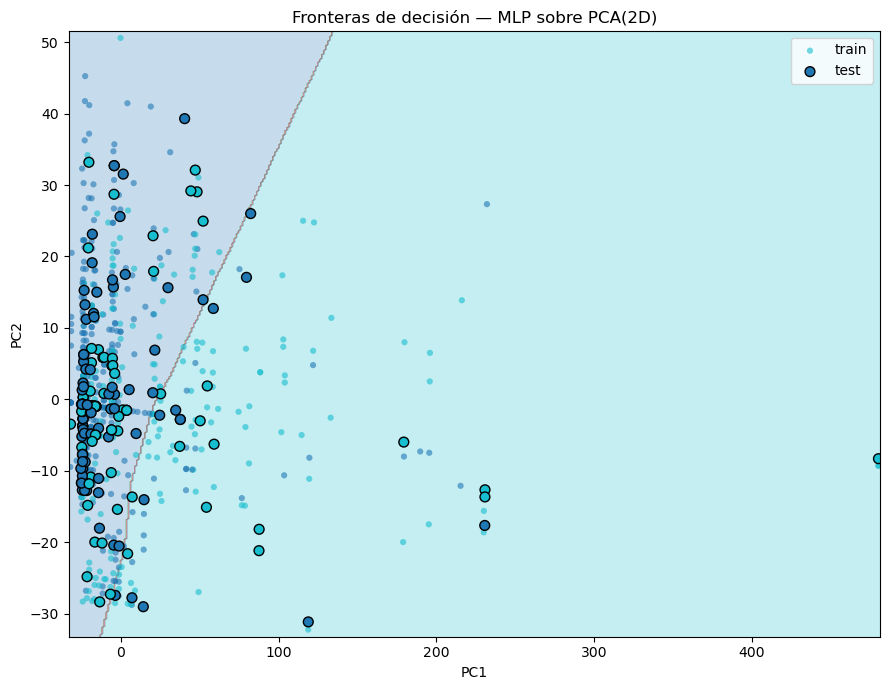

In [12]:
pca2 = PCA(n_components=2, random_state=42)
X_train_pca = pca2.fit_transform(X_train)
X_test_pca  = pca2.transform(X_test)


modelo2 = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(300,),
        activation="relu",
        solver="adam",
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=50,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        random_state=42,
        verbose=False
    ))
])
modelo2.fit(X_train_pca, y_train)

x_min, x_max = X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1
y_min, y_max = X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
Z = modelo2.fit(X_train_pca, y_train).predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(9,7))
plt.contourf(xx, yy, Z, alpha=0.25, cmap="tab10")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap="tab10",
            s=20, edgecolor="none", alpha=0.6, label="train")
plt.scatter(X_test_pca[:,0],  X_test_pca[:,1],  c=y_test,  cmap="tab10",
            s=50, edgecolor="k",   label="test")
plt.title("Fronteras de decisión — MLP sobre PCA(2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()